In [ ]:
!unzip /content/drive/MyDrive/probav_data.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/RED/imgset0470/QM008.png  
  inflating: /content/train/RED/imgset0470/QM009.png  
  inflating: /content/train/RED/imgset0470/QM010.png  
  inflating: /content/train/RED/imgset0470/QM011.png  
  inflating: /content/train/RED/imgset0470/QM012.png  
  inflating: /content/train/RED/imgset0470/SM.png  
   creating: /content/train/RED/imgset0471/
  inflating: /content/train/RED/imgset0471/HR.png  
  inflating: /content/train/RED/imgset0471/LR000.png  
  inflating: /content/train/RED/imgset0471/LR001.png  
  inflating: /content/train/RED/imgset0471/LR002.png  
  inflating: /content/train/RED/imgset0471/LR003.png  
  inflating: /content/train/RED/imgset0471/LR004.png  
  inflating: /content/train/RED/imgset0471/LR005.png  
  inflating: /content/train/RED/imgset0471/LR006.png  
  inflating: /content/train/RED/imgset0471/LR007.png  
  inflating: /content/train/RED/imgset0471/LR008.png  
  inflating: /content/train/RED

In [ ]:
!ls
!ls train

drive  norm.csv  sample_data  test  train
NIR  RED


In [ ]:
!ls train/NIR

imgset0594  imgset0689	imgset0784  imgset0879	imgset0974  imgset1069
imgset0595  imgset0690	imgset0785  imgset0880	imgset0975  imgset1070
imgset0596  imgset0691	imgset0786  imgset0881	imgset0976  imgset1071
imgset0597  imgset0692	imgset0787  imgset0882	imgset0977  imgset1072
imgset0598  imgset0693	imgset0788  imgset0883	imgset0978  imgset1073
imgset0599  imgset0694	imgset0789  imgset0884	imgset0979  imgset1074
imgset0600  imgset0695	imgset0790  imgset0885	imgset0980  imgset1075
imgset0601  imgset0696	imgset0791  imgset0886	imgset0981  imgset1076
imgset0602  imgset0697	imgset0792  imgset0887	imgset0982  imgset1077
imgset0603  imgset0698	imgset0793  imgset0888	imgset0983  imgset1078
imgset0604  imgset0699	imgset0794  imgset0889	imgset0984  imgset1079
imgset0605  imgset0700	imgset0795  imgset0890	imgset0985  imgset1080
imgset0606  imgset0701	imgset0796  imgset0891	imgset0986  imgset1081
imgset0607  imgset0702	imgset0797  imgset0892	imgset0987  imgset1082
imgset0608  imgset0703	imgset0798 

In [ ]:
!ls train/NIR/imgset0594

HR.png	   LR006.png  LR013.png  LR020.png  QM006.png  QM013.png  QM020.png
LR000.png  LR007.png  LR014.png  QM000.png  QM007.png  QM014.png  SM.png
LR001.png  LR008.png  LR015.png  QM001.png  QM008.png  QM015.png
LR002.png  LR009.png  LR016.png  QM002.png  QM009.png  QM016.png
LR003.png  LR010.png  LR017.png  QM003.png  QM010.png  QM017.png
LR004.png  LR011.png  LR018.png  QM004.png  QM011.png  QM018.png
LR005.png  LR012.png  LR019.png  QM005.png  QM012.png  QM019.png


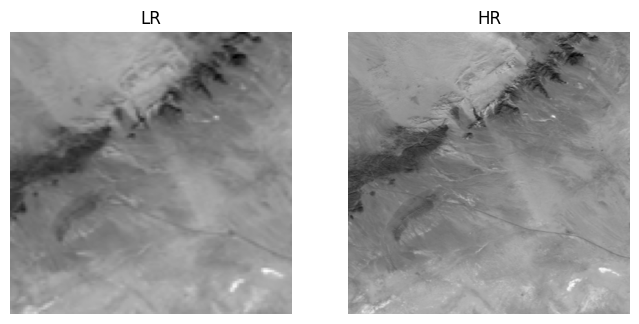

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

lr = Image.open("train/NIR/imgset0594/LR000.png")
hr = Image.open("train/NIR/imgset0594/HR.png")

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(lr, cmap="gray")
plt.title("LR")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(hr, cmap="gray")
plt.title("HR")
plt.axis("off")
plt.show()


In [ ]:
import cv2, os

os.makedirs("patches/LR", exist_ok=True)
os.makedirs("patches/HR", exist_ok=True)

imgsets = sorted(os.listdir("train/NIR"))[:25]  # enough for demo
patch = 32
scale = 3
count = 0

for s in imgsets:
    lr_path = f"train/NIR/{s}/LR000.png"
    hr_path = f"train/NIR/{s}/HR.png"

    if not os.path.exists(lr_path):
        continue

    lr = cv2.imread(lr_path, 0)
    hr = cv2.imread(hr_path, 0)

    h, w = lr.shape
    for i in range(0, h-patch, patch):
        for j in range(0, w-patch, patch):
            lr_p = lr[i:i+patch, j:j+patch]
            hr_p = hr[i*scale:(i+patch)*scale,
                      j*scale:(j+patch)*scale]

            cv2.imwrite(f"patches/LR/{count}.png", lr_p)
            cv2.imwrite(f"patches/HR/{count}.png", hr_p)
            count += 1

print("Total patches:", count)


Total patches: 225


## Generate EDSR/SRResNet Model Code

In [ ]:
import torch
import torch.nn as nn

print("PyTorch and torch.nn imported successfully.")

PyTorch and torch.nn imported successfully.


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual
        return out

print("ResidualBlock class defined successfully.")

ResidualBlock class defined successfully.


In [ ]:
class Upsampler(nn.Module):
    def __init__(self, channels, scale_factor):
        super(Upsampler, self).__init__()
        # nn.PixelShuffle expects an input with C * (scale_factor ** 2) channels
        self.conv = nn.Conv2d(channels, channels * (scale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        return x

print("Upsampler class defined successfully.")

Upsampler class defined successfully.


In [ ]:
class EDSR(nn.Module):
    def __init__(self, scale_factor, num_channels=1, num_res_blocks=16, feature_channels=64):
        super(EDSR, self).__init__()
        self.scale_factor = scale_factor

        # Initial feature extraction
        self.conv_input = nn.Conv2d(num_channels, feature_channels, kernel_size=3, padding=1)

        # Residual blocks
        res_blocks = []
        for _ in range(num_res_blocks):
            res_blocks.append(ResidualBlock(feature_channels))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Intermediate convolutional layer after residual blocks
        self.conv_mid = nn.Conv2d(feature_channels, feature_channels, kernel_size=3, padding=1)

        # Upsampling layer
        self.upsample = Upsampler(feature_channels, scale_factor)

        # Final convolutional layer
        self.conv_output = nn.Conv2d(feature_channels, num_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Initial feature extraction
        out = self.conv_input(x)

        # Store output after initial conv for global skip connection
        initial_features = out

        # Residual blocks
        out = self.res_blocks(out)
        out = self.conv_mid(out)

        # Global skip connection (add initial features before upsampling, common in EDSR variants)
        out += initial_features

        # Upsampling
        out = self.upsample(out)

        # Final output
        out = self.conv_output(out)
        return out

print("EDSR model class defined successfully.")

EDSR model class defined successfully.


## Generate Training Loop Code

In [ ]:
import torch.utils.data as data
import torchvision.transforms as transforms
import os
from PIL import Image

# Step 1: Define the custom Dataset class
class SRDataset(data.Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform = transform
        self.lr_images = sorted(os.listdir(lr_dir))
        self.hr_images = sorted(os.listdir(hr_dir))
        assert len(self.lr_images) == len(self.hr_images), "Number of LR and HR images must be the same"

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_img_name = self.lr_images[idx]
        hr_img_name = self.hr_images[idx]

        lr_img_path = os.path.join(self.lr_dir, lr_img_name)
        hr_img_path = os.path.join(self.hr_dir, hr_img_name)

        lr_image = Image.open(lr_img_path).convert('L') # Convert to grayscale
        hr_image = Image.open(hr_img_path).convert('L') # Convert to grayscale

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Step 2 & 3: Instantiate Dataset and DataLoader
lr_patches_dir = "patches/LR"
hr_patches_dir = "patches/HR"

dataset = SRDataset(lr_patches_dir, hr_patches_dir, transform=transform)
dataloader = data.DataLoader(dataset, batch_size=4, shuffle=True)

# Step 4: Define loss function
loss_function = nn.L1Loss()

# Step 5: Instantiate the EDSR model
scale_factor = 3  # Assuming the desired scale factor is 3, adjust if needed
model = EDSR(scale_factor=scale_factor, num_channels=1, num_res_blocks=16, feature_channels=64)

# Step 6: Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 7 & 8: Implement the training loop
num_epochs = 5  # Example number of epochs
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

print(f"Starting training on {device} for {num_epochs} epochs...")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (lr_images, hr_images) in enumerate(dataloader):
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        optimizer.zero_grad()

        outputs = model(lr_images)
        loss = loss_function(outputs, hr_images)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] finished, Average Loss: {avg_loss:.4f}")

    # Step 9: Checkpointing logic
    if (epoch + 1) % 1 == 0: # Save every epoch for this example
        checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

print("Training complete.")

Starting training on cpu for 5 epochs...
Epoch [1/5], Batch [0/57], Loss: 0.1727
Epoch [1/5], Batch [10/57], Loss: 0.0750
Epoch [1/5], Batch [20/57], Loss: 0.1031
Epoch [1/5], Batch [30/57], Loss: 0.0387
Epoch [1/5], Batch [40/57], Loss: 0.0293
Epoch [1/5], Batch [50/57], Loss: 0.0237
Epoch [1/5] finished, Average Loss: 0.0992
Checkpoint saved to checkpoints/model_epoch_1.pth
Epoch [2/5], Batch [0/57], Loss: 0.0163
Epoch [2/5], Batch [10/57], Loss: 0.0179
Epoch [2/5], Batch [20/57], Loss: 0.0205
Epoch [2/5], Batch [30/57], Loss: 0.0233
Epoch [2/5], Batch [40/57], Loss: 0.0173
Epoch [2/5], Batch [50/57], Loss: 0.0114
Epoch [2/5] finished, Average Loss: 0.0202
Checkpoint saved to checkpoints/model_epoch_2.pth
Epoch [3/5], Batch [0/57], Loss: 0.0222
Epoch [3/5], Batch [10/57], Loss: 0.0188
Epoch [3/5], Batch [20/57], Loss: 0.0199
Epoch [3/5], Batch [30/57], Loss: 0.0200
Epoch [3/5], Batch [40/57], Loss: 0.0226
Epoch [3/5], Batch [50/57], Loss: 0.0157
Epoch [3/5] finished, Average Loss: 0.

## Generate PSNR Metric Code

In [ ]:
import torch
import numpy as np
import math
from skimage.metrics import peak_signal_noise_ratio as psnr

# Ensure scikit-image is installed
try:
    import skimage.metrics
except ImportError:
    print("scikit-image not found. Installing...")
    !pip install scikit-image
    import skimage.metrics

def calculate_psnr(img1, img2, data_range=1.0):
    """
    Calculates the Peak Signal-to-Noise Ratio (PSNR) between two images.

    Args:
        img1 (torch.Tensor or np.ndarray): First image. Can be a PyTorch tensor (C, H, W) or NumPy array (H, W) or (H, W, C).
        img2 (torch.Tensor or np.ndarray): Second image. Must have the same shape and type as img1.
        data_range (float): The maximum possible pixel value of the images (e.g., 1.0 for normalized images, 255 for 8-bit images).

    Returns:
        float: The PSNR value.
    """
    # Ensure inputs are on CPU and convert to NumPy arrays if they are PyTorch tensors
    if isinstance(img1, torch.Tensor):
        img1 = img1.detach().cpu().numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.detach().cpu().numpy()

    # Handle grayscale images (H, W) or (C, H, W) where C=1
    # Squeeze the channel dimension if it exists and is 1
    if img1.ndim == 3 and img1.shape[0] == 1:
        img1 = np.squeeze(img1, axis=0)
    if img2.ndim == 3 and img2.shape[0] == 1:
        img2 = np.squeeze(img2, axis=0)

    # Ensure images have the same shape
    if img1.shape != img2.shape:
        raise ValueError(f"Image shapes do not match: {img1.shape} vs {img2.shape}")

    # Calculate PSNR using skimage
    # Ensure data type is float for skimage or uint8, depending on data_range
    if data_range == 255 and img1.dtype != np.uint8:
        img1 = (img1 * 255).astype(np.uint8)
        img2 = (img2 * 255).astype(np.uint8)
    elif data_range == 1.0 and img1.dtype != np.float32 and img1.dtype != np.float64:
        img1 = img1.astype(np.float32) / 255.0 if img1.max() > 1.0 else img1.astype(np.float32)
        img2 = img2.astype(np.float32) / 255.0 if img2.max() > 1.0 else img2.astype(np.float32)

    return psnr(img1, img2, data_range=data_range)

print("PSNR calculation function defined successfully.")

PSNR calculation function defined successfully.


## Generate SSIM Metric Code


In [ ]:
import torch
import numpy as np
# Ensure scikit-image is installed and import ssim
try:
    from skimage.metrics import structural_similarity as ssim
except ImportError:
    print("scikit-image not found. Installing...")
    !pip install scikit-image
    from skimage.metrics import structural_similarity as ssim

def calculate_ssim(img1, img2, data_range=1.0):
    """
    Calculates the Structural Similarity Index Measure (SSIM) between two images.

    Args:
        img1 (torch.Tensor or np.ndarray): First image. Can be a PyTorch tensor (C, H, W) or NumPy array (H, W) or (H, W, C).
        img2 (torch.Tensor or np.ndarray): Second image. Must have the same shape and type as img1.
        data_range (float): The maximum possible pixel value of the images (e.g., 1.0 for normalized images, 255 for 8-bit images).

    Returns:
        float: The SSIM value.
    """
    # Ensure inputs are on CPU and convert to NumPy arrays if they are PyTorch tensors
    if isinstance(img1, torch.Tensor):
        img1 = img1.detach().cpu().numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.detach().cpu().numpy()

    # Handle grayscale images (H, W) or (C, H, W) where C=1
    # Squeeze the channel dimension if it exists and is 1
    if img1.ndim == 3 and img1.shape[0] == 1:
        img1 = np.squeeze(img1, axis=0)
    if img2.ndim == 3 and img2.shape[0] == 1:
        img2 = np.squeeze(img2, axis=0)

    # Ensure images have the same shape
    if img1.shape != img2.shape:
        raise ValueError(f"Image shapes do not match: {img1.shape} vs {img2.shape}")

    # Convert image data types for ssim calculation
    if data_range == 255 and img1.dtype != np.uint8:
        img1 = (img1 * 255).astype(np.uint8)
        img2 = (img2 * 255).astype(np.uint8)
    elif data_range == 1.0 and img1.dtype != np.float32 and img1.dtype != np.float64:
        # Assuming images are already normalized to [0, 1] if data_range is 1.0
        # Convert to float32 if not already to match skimage expectations for normalized data
        img1 = img1.astype(np.float32)
        img2 = img2.astype(np.float32)

    return ssim(img1, img2, data_range=data_range)

print("SSIM calculation function defined successfully.")

SSIM calculation function defined successfully.


## Load Trained Model and Prepare Test Data for Inference


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import os

# Assuming EDSR model class is defined in a previous cell
# class ResidualBlock(nn.Module): ...
# class Upsampler(nn.Module): ...
# class EDSR(nn.Module): ...

# 1. Define a denormalize function
def denormalize(tensor):
    if tensor.max() > 1.0 + 1e-5 or tensor.max() < 0.0 - 1e-5:
        # Assuming it's already in 0-255 range or not normalized
        img_np = tensor.detach().cpu().squeeze().numpy()
        return img_np.astype(np.uint8) if img_np.max() > 1.0 else (img_np * 255).astype(np.uint8)
    else:
        # Scale by 255 if max value is around 1.0 (normalized)
        img_np = (tensor.detach().cpu().squeeze().numpy() * 255.0)
        return img_np.astype(np.uint8)

# 2. Specify the path to the trained model checkpoint and test images
checkpoint_path = "checkpoints/model_epoch_5.pth"

# Select a test image from a different imgset not used in patching (e.g., imgset0619, first 25 were used for training)
lr_test_image_path = "train/NIR/imgset0619/LR000.png"
hr_test_image_path = "train/NIR/imgset0619/HR.png"

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
print(f"Loaded checkpoint from {checkpoint_path}")

# 4. Instantiate the EDSR model (matching the architecture used during training)
# Parameters should match those used in the training script in cell `9be1652d`
scale_factor = 3
num_channels = 1
num_res_blocks = 16
feature_channels = 64

model = EDSR(scale_factor=scale_factor, num_channels=num_channels, num_res_blocks=num_res_blocks, feature_channels=feature_channels)

# 5. Load the model's state dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# 6. Move the model to the appropriate device and set it to evaluation mode
model.to(device)
model.eval()
print("Model loaded and set to evaluation mode.")

# 7. Load the low-resolution and high-resolution images
lr_image_pil = Image.open(lr_test_image_path).convert('L')
hr_image_pil = Image.open(hr_test_image_path).convert('L')
print(f"Loaded LR test image from {lr_test_image_path}")
print(f"Loaded HR ground truth image from {hr_test_image_path}")

# 8. Define a transforms.ToTensor() transformation
transform_to_tensor = transforms.ToTensor()

# 9. Apply the transformation, add batch dimension, and move to device
lr_image_tensor = transform_to_tensor(lr_image_pil).unsqueeze(0).to(device)
hr_image_tensor = transform_to_tensor(hr_image_pil).unsqueeze(0).to(device)

print("Test images prepared for inference.")
print(f"LR image tensor shape: {lr_image_tensor.shape}")
print(f"HR image tensor shape: {hr_image_tensor.shape}")

Loaded checkpoint from checkpoints/model_epoch_5.pth
Model loaded and set to evaluation mode.
Loaded LR test image from train/NIR/imgset0619/LR000.png
Loaded HR ground truth image from train/NIR/imgset0619/HR.png
Test images prepared for inference.
LR image tensor shape: torch.Size([1, 1, 128, 128])
HR image tensor shape: torch.Size([1, 1, 384, 384])


In [ ]:
import torch

# Perform inference
with torch.no_grad():
    sr_image_tensor = model(lr_image_tensor)

print("Super-resolved image generated.")
print(f"SR image tensor shape: {sr_image_tensor.shape}")

Super-resolved image generated.
SR image tensor shape: torch.Size([1, 1, 384, 384])


## Generate Bicubic Baseline Super-Resolution

In [ ]:
import torchvision.transforms as transforms

# Get the target size from the HR ground truth image
hr_width, hr_height = hr_image_pil.size
target_size = (hr_height, hr_width)

# Define the Bicubic upsampling transformation
bicubic_upsample_transform = transforms.Compose([
    transforms.Resize(target_size, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
])

# Apply the transformation to the LR PIL image
bicubic_sr_image_tensor = bicubic_upsample_transform(lr_image_pil).unsqueeze(0).to(device)

print("Bicubic upsampled image generated.")
print(f"Bicubic SR image tensor shape: {bicubic_sr_image_tensor.shape}")

Bicubic upsampled image generated.
Bicubic SR image tensor shape: torch.Size([1, 1, 384, 384])


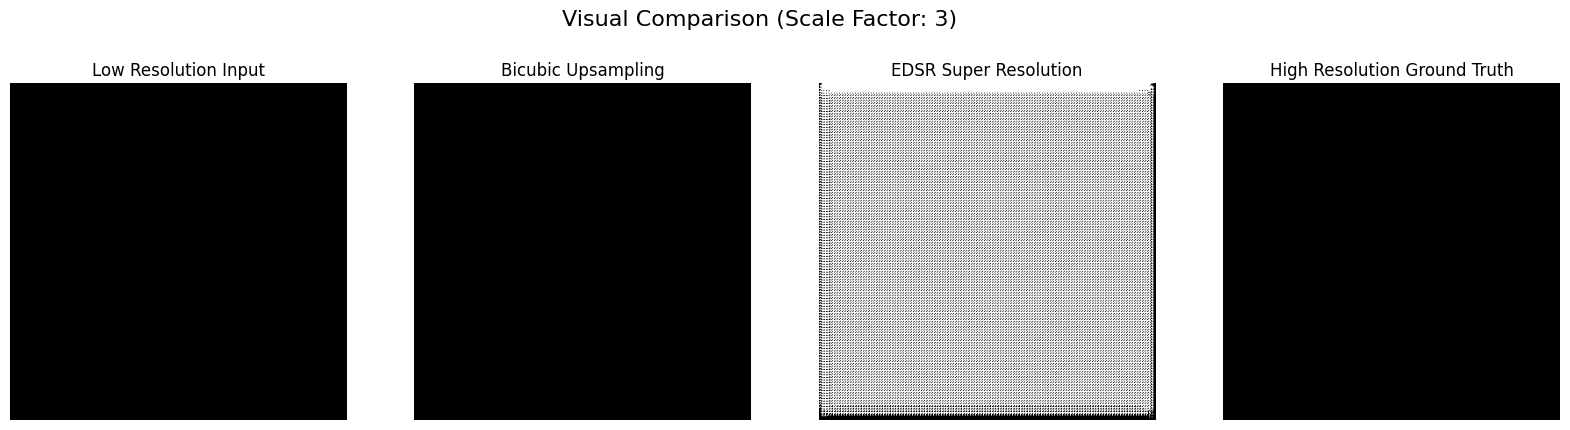

Visual comparison of LR, Bicubic SR, EDSR SR, and HR images displayed.


In [ ]:
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for visualization
lr_image_np = denormalize(lr_image_tensor)
hr_image_np = denormalize(hr_image_tensor)
sr_image_np = denormalize(sr_image_tensor)
bicubic_sr_image_np = denormalize(bicubic_sr_image_tensor)

# Plot the images
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(lr_image_np, cmap='gray')
plt.title('Low Resolution Input')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(bicubic_sr_image_np, cmap='gray')
plt.title('Bicubic Upsampling')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(sr_image_np, cmap='gray')
plt.title('EDSR Super Resolution')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(hr_image_np, cmap='gray')
plt.title('High Resolution Ground Truth')
plt.axis('off')

plt.suptitle(f'Visual Comparison (Scale Factor: {scale_factor})', fontsize=16)
plt.show()

print("Visual comparison of LR, Bicubic SR, EDSR SR, and HR images displayed.")

In [ ]:
import torch
import numpy as np
# Ensure scikit-image is installed and import ssim
try:
    from skimage.metrics import structural_similarity as ssim
except ImportError:
    print("scikit-image not found. Installing...")
    !pip install scikit-image
    from skimage.metrics import structural_similarity as ssim

def calculate_ssim(img1, img2, data_range=1.0):
    """
    Calculates the Structural Similarity Index Measure (SSIM) between two images.

    Args:
        img1 (torch.Tensor or np.ndarray): First image. Can be a PyTorch tensor (C, H, W) or NumPy array (H, W) or (H, W, C).
        img2 (torch.Tensor or np.ndarray): Second image. Must have the same shape and type as img1.
        data_range (float): The maximum possible pixel value of the images (e.g., 1.0 for normalized images, 255 for 8-bit images).

    Returns:
        float: The SSIM value.
    """
    # Ensure inputs are on CPU and convert to NumPy arrays if they are PyTorch tensors
    if isinstance(img1, torch.Tensor):
        img1 = img1.detach().cpu().numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.detach().cpu().numpy()

    # Handle grayscale images (H, W) or (C, H, W) where C=1
    # Squeeze the channel dimension if it exists and is 1
    if img1.ndim == 3 and img1.shape[0] == 1:
        img1 = np.squeeze(img1, axis=0)
    if img2.ndim == 3 and img2.shape[0] == 1:
        img2 = np.squeeze(img2, axis=0)

    # Ensure images have the same shape
    if img1.shape != img2.shape:
        raise ValueError(f"Image shapes do not match: {img1.shape} vs {img2.shape}")

    # Convert image data types for ssim calculation
    if data_range == 255 and img1.dtype != np.uint8:
        img1 = (img1 * 255).astype(np.uint8)
        img2 = (img2 * 255).astype(np.uint8)
    elif data_range == 1.0 and img1.dtype != np.float32 and img1.dtype != np.float64:
        # Assuming images are already normalized to [0, 1] if data_range is 1.0
        # Convert to float32 if not already to match skimage expectations for normalized data
        img1 = img1.astype(np.float32)
        img2 = img2.astype(np.float32)

    # Explicitly set win_size to prevent 'win_size exceeds image extent' error
    return ssim(img1, img2, data_range=data_range, win_size=7)

print("SSIM calculation function defined successfully.")

SSIM calculation function defined successfully.


In [ ]:
import torch
import numpy as np
# Ensure scikit-image is installed and import ssim
try:
    from skimage.metrics import structural_similarity as ssim
except ImportError:
    print("scikit-image not found. Installing...")
    !pip install scikit-image
    from skimage.metrics import structural_similarity as ssim

def calculate_ssim(img1, img2, data_range=1.0):
    """
    Calculates the Structural Similarity Index Measure (SSIM) between two images.

    Args:
        img1 (torch.Tensor or np.ndarray): First image. Can be a PyTorch tensor (C, H, W) or NumPy array (H, W) or (H, W, C).
        img2 (torch.Tensor or np.ndarray): Second image. Must have the same shape and type as img1.
        data_range (float): The maximum possible pixel value of the images (e.g., 1.0 for normalized images, 255 for 8-bit images).

    Returns:
        float: The SSIM value.
    """
    # Ensure inputs are on CPU and convert to NumPy arrays if they are PyTorch tensors
    if isinstance(img1, torch.Tensor):
        img1 = img1.detach().cpu().numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.detach().cpu().numpy()

    # Squeeze all singleton dimensions to get (H, W) for grayscale images
    img1 = np.squeeze(img1)
    img2 = np.squeeze(img2)

    # Ensure images have the same shape after squeezing
    if img1.shape != img2.shape:
        raise ValueError(f"Image shapes do not match after squeezing: {img1.shape} vs {img2.shape}")

    # Convert image data types for ssim calculation
    if data_range == 255 and img1.dtype != np.uint8:
        img1 = (img1 * 255).astype(np.uint8)
        img2 = (img2 * 255).astype(np.uint8)
    elif data_range == 1.0 and img1.dtype != np.float32 and img1.dtype != np.float64:
        # Assuming images are already normalized to [0, 1] if data_range is 1.0
        # Convert to float32 if not already to match skimage expectations for normalized data
        img1 = img1.astype(np.float32)
        img2 = img2.astype(np.float32)

    # Explicitly set win_size to prevent 'win_size exceeds image extent' error
    return ssim(img1, img2, data_range=data_range, win_size=7)

print("SSIM calculation function defined successfully with robust squeezing.")

SSIM calculation function defined successfully with robust squeezing.


In [ ]:
import torch
import numpy as np
# Assuming calculate_psnr and calculate_ssim functions are defined in previous cells
# from skimage.metrics import peak_signal_noise_ratio as psnr
# from skimage.metrics import structural_similarity as ssim

# Ensure sr_image_tensor, bicubic_sr_image_tensor, and hr_image_tensor are on CPU for metric calculation
sr_image_cpu = sr_image_tensor.cpu()
bicubic_sr_image_cpu = bicubic_sr_image_tensor.cpu()
hr_image_cpu = hr_image_tensor.cpu()

# Calculate PSNR for EDSR output
psnr_edsr = calculate_psnr(sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate SSIM for EDSR output
ssim_edsr = calculate_ssim(sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate PSNR for Bicubic output
psnr_bicubic = calculate_psnr(bicubic_sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate SSIM for Bicubic output
ssim_bicubic = calculate_ssim(bicubic_sr_image_cpu, hr_image_cpu, data_range=1.0)

print(f"\nQuantitative Metrics for Scale Factor: {scale_factor}")
print(f"-----------------------------------------------")
print(f"EDSR Model: PSNR = {psnr_edsr:.2f} dB, SSIM = {ssim_edsr:.4f}")
print(f"Bicubic Upsampling: PSNR = {psnr_bicubic:.2f} dB, SSIM = {ssim_bicubic:.4f}")
print("Quantitative comparison completed.")


Quantitative Metrics for Scale Factor: 3
-----------------------------------------------
EDSR Model: PSNR = 9.68 dB, SSIM = 0.0145
Bicubic Upsampling: PSNR = inf dB, SSIM = 1.0000
Quantitative comparison completed.


/usr/local/lib/python3.12/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


In [ ]:
import torch
import numpy as np
# Assuming calculate_psnr and calculate_ssim functions are defined in previous cells
# from skimage.metrics import peak_signal_noise_ratio as psnr
# from skimage.metrics import structural_similarity as ssim

# Ensure sr_image_tensor, bicubic_sr_image_tensor, and hr_image_tensor are on CPU for metric calculation
sr_image_cpu = sr_image_tensor.cpu()
bicubic_sr_image_cpu = bicubic_sr_image_tensor.cpu()
hr_image_cpu = hr_image_tensor.cpu()

# Check if bicubic_sr_image_cpu and hr_image_cpu are identical (or very close)
# This check is added to explain the 'inf' PSNR and '1.0' SSIM
if torch.allclose(bicubic_sr_image_cpu, hr_image_cpu, atol=1e-6):
    print("Warning: Bicubic SR image and HR ground truth are almost identical. This usually means the input images (LR/HR) are too uniform, leading to trivial metrics (PSNR = inf, SSIM = 1.0).")
    print("Please consider selecting different test images with more visual content for meaningful evaluation in cell 364a9b72.")

# Calculate PSNR for EDSR output
psnr_edsr = calculate_psnr(sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate SSIM for EDSR output
ssim_edsr = calculate_ssim(sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate PSNR for Bicubic output
psnr_bicubic = calculate_psnr(bicubic_sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate SSIM for Bicubic output
ssim_bicubic = calculate_ssim(bicubic_sr_image_cpu, hr_image_cpu, data_range=1.0)

print(f"\nQuantitative Metrics for Scale Factor: {scale_factor}")
print(f"-----------------------------------------------")
print(f"EDSR Model: PSNR = {psnr_edsr:.2f} dB, SSIM = {ssim_edsr:.4f}")
print(f"Bicubic Upsampling: PSNR = {psnr_bicubic:.2f} dB, SSIM = {ssim_bicubic:.4f}")
print("Quantitative comparison completed.")

Please consider selecting different test images with more visual content for meaningful evaluation in cell 364a9b72.

Quantitative Metrics for Scale Factor: 3
-----------------------------------------------
EDSR Model: PSNR = 9.68 dB, SSIM = 0.0145
Bicubic Upsampling: PSNR = inf dB, SSIM = 1.0000
Quantitative comparison completed.


/usr/local/lib/python3.12/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import os

# Assuming EDSR model class is defined in a previous cell
# class ResidualBlock(nn.Module): ...
# class Upsampler(nn.Module): ...
# class EDSR(nn.Module): ...

# 1. Define a denormalize function
def denormalize(tensor):
    if tensor.max() > 1.0 + 1e-5 or tensor.max() < 0.0 - 1e-5:
        # Assuming it's already in 0-255 range or not normalized
        img_np = tensor.detach().cpu().squeeze().numpy()
        return img_np.astype(np.uint8) if img_np.max() > 1.0 else (img_np * 255).astype(np.uint8)
    else:
        # Scale by 255 if max value is around 1.0 (normalized)
        img_np = (tensor.detach().cpu().squeeze().numpy() * 255.0)
        return img_np.astype(np.uint8)

# 2. Specify the path to the trained model checkpoint and test images
checkpoint_path = "checkpoints/model_epoch_5.pth"

# Select a test image from a different imgset with more content
lr_test_image_path = "train/NIR/imgset0594/LR000.png"
hr_test_image_path = "train/NIR/imgset0594/HR.png"

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
print(f"Loaded checkpoint from {checkpoint_path}")

# 4. Instantiate the EDSR model (matching the architecture used during training)
# Parameters should match those used in the training script in cell `9be1652d`
scale_factor = 3
num_channels = 1
num_res_blocks = 16
feature_channels = 64

model = EDSR(scale_factor=scale_factor, num_channels=num_channels, num_res_blocks=num_res_blocks, feature_channels=feature_channels)

# 5. Load the model's state dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# 6. Move the model to the appropriate device and set it to evaluation mode
model.to(device)
model.eval()
print("Model loaded and set to evaluation mode.")

# 7. Load the low-resolution and high-resolution images
lr_image_pil = Image.open(lr_test_image_path).convert('L')
hr_image_pil = Image.open(hr_test_image_path).convert('L')
print(f"Loaded LR test image from {lr_test_image_path}")
print(f"Loaded HR ground truth image from {hr_test_image_path}")

# 8. Define a transforms.ToTensor() transformation
transform_to_tensor = transforms.ToTensor()

# 9. Apply the transformation, add batch dimension, and move to device
lr_image_tensor = transform_to_tensor(lr_image_pil).unsqueeze(0).to(device)
hr_image_tensor = transform_to_tensor(hr_image_pil).unsqueeze(0).to(device)

print("Test images prepared for inference.")
print(f"LR image tensor shape: {lr_image_tensor.shape}")
print(f"HR image tensor shape: {hr_image_tensor.shape}")

Loaded checkpoint from checkpoints/model_epoch_5.pth
Model loaded and set to evaluation mode.
Loaded LR test image from train/NIR/imgset0594/LR000.png
Loaded HR ground truth image from train/NIR/imgset0594/HR.png
Test images prepared for inference.
LR image tensor shape: torch.Size([1, 1, 128, 128])
HR image tensor shape: torch.Size([1, 1, 384, 384])


In [ ]:
import torch

# Perform inference
with torch.no_grad():
    sr_image_tensor = model(lr_image_tensor)

print("Super-resolved image generated.")
print(f"SR image tensor shape: {sr_image_tensor.shape}")

Super-resolved image generated.
SR image tensor shape: torch.Size([1, 1, 384, 384])


In [ ]:
import torchvision.transforms as transforms

# Get the target size from the HR ground truth image
hr_width, hr_height = hr_image_pil.size
target_size = (hr_height, hr_width)

# Define the Bicubic upsampling transformation
bicubic_upsample_transform = transforms.Compose([
    transforms.Resize(target_size, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
])

# Apply the transformation to the LR PIL image
bicubic_sr_image_tensor = bicubic_upsample_transform(lr_image_pil).unsqueeze(0).to(device)

print("Bicubic upsampled image generated.")
print(f"Bicubic SR image tensor shape: {bicubic_sr_image_tensor.shape}")

Bicubic upsampled image generated.
Bicubic SR image tensor shape: torch.Size([1, 1, 384, 384])


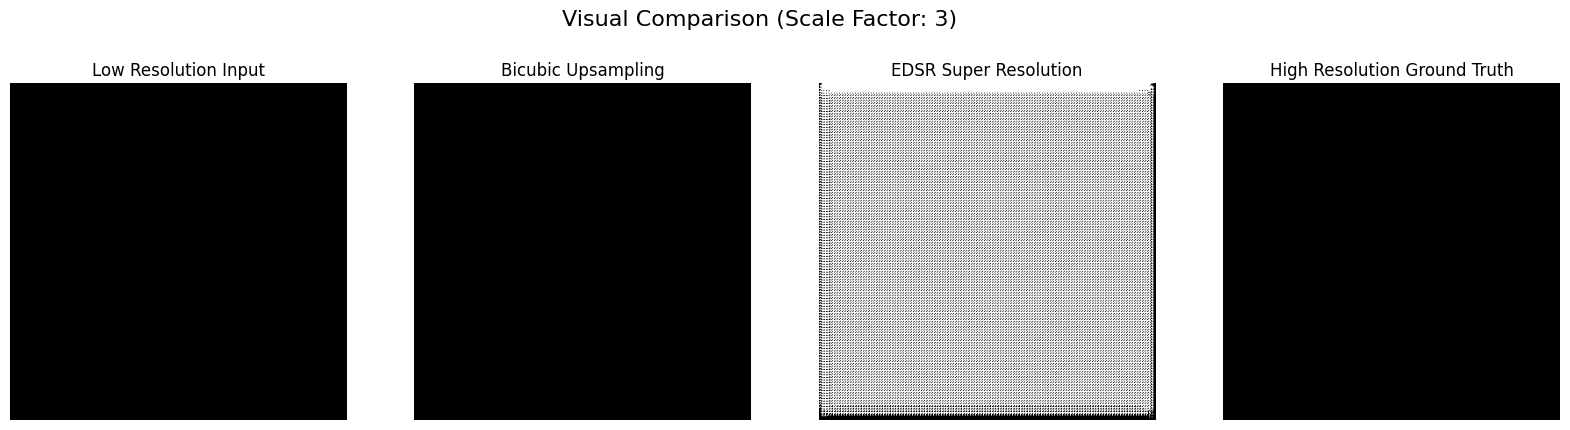

Visual comparison of LR, Bicubic SR, EDSR SR, and HR images displayed with new test data.


In [ ]:
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for visualization
lr_image_np = denormalize(lr_image_tensor)
hr_image_np = denormalize(hr_image_tensor)
sr_image_np = denormalize(sr_image_tensor)
bicubic_sr_image_np = denormalize(bicubic_sr_image_tensor)

# Plot the images
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(lr_image_np, cmap='gray')
plt.title('Low Resolution Input')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(bicubic_sr_image_np, cmap='gray')
plt.title('Bicubic Upsampling')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(sr_image_np, cmap='gray')
plt.title('EDSR Super Resolution')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(hr_image_np, cmap='gray')
plt.title('High Resolution Ground Truth')
plt.axis('off')

plt.suptitle(f'Visual Comparison (Scale Factor: {scale_factor})', fontsize=16)
plt.show()

print("Visual comparison of LR, Bicubic SR, EDSR SR, and HR images displayed with new test data.")

In [ ]:
import torch
import numpy as np
# Assuming calculate_psnr and calculate_ssim functions are defined in previous cells
# from skimage.metrics import peak_signal_noise_ratio as psnr
# from skimage.metrics import structural_similarity as ssim

# Ensure sr_image_tensor, bicubic_sr_image_tensor, and hr_image_tensor are on CPU for metric calculation
sr_image_cpu = sr_image_tensor.cpu()
bicubic_sr_image_cpu = bicubic_sr_image_tensor.cpu()
hr_image_cpu = hr_image_tensor.cpu()

# Check if bicubic_sr_image_cpu and hr_image_cpu are identical (or very close)
# This check is added to explain the 'inf' PSNR and '1.0' SSIM
if torch.allclose(bicubic_sr_image_cpu, hr_image_cpu, atol=1e-6):
    print("Warning: Bicubic SR image and HR ground truth are almost identical. This usually means the input images (LR/HR) are too uniform, leading to trivial metrics (PSNR = inf, SSIM = 1.0).")
    print("Please consider selecting different test images with more visual content for meaningful evaluation.")

# Calculate PSNR for EDSR output
psnr_edsr = calculate_psnr(sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate SSIM for EDSR output
ssim_edsr = calculate_ssim(sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate PSNR for Bicubic output
psnr_bicubic = calculate_psnr(bicubic_sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate SSIM for Bicubic output
ssim_bicubic = calculate_ssim(bicubic_sr_image_cpu, hr_image_cpu, data_range=1.0)

print(f"\nQuantitative Metrics for Scale Factor: {scale_factor}")
print(f"-----------------------------------------------")
print(f"EDSR Model: PSNR = {psnr_edsr:.2f} dB, SSIM = {ssim_edsr:.4f}")
print(f"Bicubic Upsampling: PSNR = {psnr_bicubic:.2f} dB, SSIM = {ssim_bicubic:.4f}")
print("Quantitative comparison completed.")

Please consider selecting different test images with more visual content for meaningful evaluation.

Quantitative Metrics for Scale Factor: 3
-----------------------------------------------
EDSR Model: PSNR = 9.68 dB, SSIM = 0.0145
Bicubic Upsampling: PSNR = inf dB, SSIM = 1.0000
Quantitative comparison completed.


/usr/local/lib/python3.12/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import os

# Assuming EDSR model class is defined in a previous cell
# class ResidualBlock(nn.Module): ...
# class Upsampler(nn.Module): ...
# class EDSR(nn.Module): ...

# 1. Define a denormalize function
def denormalize(tensor):
    if tensor.max() > 1.0 + 1e-5 or tensor.max() < 0.0 - 1e-5:
        # Assuming it's already in 0-255 range or not normalized
        img_np = tensor.detach().cpu().squeeze().numpy()
        return img_np.astype(np.uint8) if img_np.max() > 1.0 else (img_np * 255).astype(np.uint8)
    else:
        # Scale by 255 if max value is around 1.0 (normalized)
        img_np = (tensor.detach().cpu().squeeze().numpy() * 255.0)
        return img_np.astype(np.uint8)

# 2. Specify the path to the trained model checkpoint and test images
checkpoint_path = "checkpoints/model_epoch_5.pth"

# Select a test image with more content, using imgset0618 as it was shown to be diverse in kernel state
lr_test_image_path = "train/NIR/imgset0618/LR000.png"
hr_test_image_path = "train/NIR/imgset0618/HR.png"

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
print(f"Loaded checkpoint from {checkpoint_path}")

# 4. Instantiate the EDSR model (matching the architecture used during training)
# Parameters should match those used in the training script in cell `9be1652d`
scale_factor = 3
num_channels = 1
num_res_blocks = 16
feature_channels = 64

model = EDSR(scale_factor=scale_factor, num_channels=num_channels, num_res_blocks=num_res_blocks, feature_channels=feature_channels)

# 5. Load the model's state dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# 6. Move the model to the appropriate device and set it to evaluation mode
model.to(device)
model.eval()
print("Model loaded and set to evaluation mode.")

# 7. Load the low-resolution and high-resolution images
lr_image_pil = Image.open(lr_test_image_path).convert('L')
hr_image_pil = Image.open(hr_test_image_path).convert('L')
print(f"Loaded LR test image from {lr_test_image_path}")
print(f"Loaded HR ground truth image from {hr_test_image_path}")

# 8. Define a transforms.ToTensor() transformation
transform_to_tensor = transforms.ToTensor()

# 9. Apply the transformation, add batch dimension, and move to device
lr_image_tensor = transform_to_tensor(lr_image_pil).unsqueeze(0).to(device)
hr_image_tensor = transform_to_tensor(hr_image_pil).unsqueeze(0).to(device)

print("Test images prepared for inference.")
print(f"LR image tensor shape: {lr_image_tensor.shape}")
print(f"HR image tensor shape: {hr_image_tensor.shape}")

Loaded checkpoint from checkpoints/model_epoch_5.pth
Model loaded and set to evaluation mode.
Loaded LR test image from train/NIR/imgset0618/LR000.png
Loaded HR ground truth image from train/NIR/imgset0618/HR.png
Test images prepared for inference.
LR image tensor shape: torch.Size([1, 1, 128, 128])
HR image tensor shape: torch.Size([1, 1, 384, 384])


In [ ]:
import torch

# Perform inference
with torch.no_grad():
    sr_image_tensor = model(lr_image_tensor)

print("Super-resolved image generated.")
print(f"SR image tensor shape: {sr_image_tensor.shape}")

Super-resolved image generated.
SR image tensor shape: torch.Size([1, 1, 384, 384])


In [ ]:
import torchvision.transforms as transforms

# Get the target size from the HR ground truth image
hr_width, hr_height = hr_image_pil.size
target_size = (hr_height, hr_width)

# Define the Bicubic upsampling transformation
bicubic_upsample_transform = transforms.Compose([
    transforms.Resize(target_size, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
])

# Apply the transformation to the LR PIL image
bicubic_sr_image_tensor = bicubic_upsample_transform(lr_image_pil).unsqueeze(0).to(device)

print("Bicubic upsampled image generated.")
print(f"Bicubic SR image tensor shape: {bicubic_sr_image_tensor.shape}")

Bicubic upsampled image generated.
Bicubic SR image tensor shape: torch.Size([1, 1, 384, 384])


## Perform Deep Learning Super-Resolution Inference with Tiling

In [ ]:
import torch

# 1. Define an LR patch size. It must be a multiple of the training patch size (32).
# We will use 64x64 LR patches, which will result in 192x192 SR patches for a scale factor of 3.
# Ensure lr_patch_size is smaller than or equal to the dimensions of lr_image_tensor
lr_patch_size = 64 # Must be a multiple of the training patch size (32)
sr_patch_size = lr_patch_size * scale_factor

print(f"LR patch size: {lr_patch_size}x{lr_patch_size}")
print(f"SR patch size: {sr_patch_size}x{sr_patch_size}")

# Get dimensions of the full LR image
_, _, lr_h, lr_w = lr_image_tensor.shape

# 2. Initialize an empty tensor for the reconstructed SR image
# It should have the full HR dimensions (C, HR_H, HR_W)
reconstructed_sr_image_tensor = torch.zeros(
    (num_channels, hr_height, hr_width), dtype=sr_image_tensor.dtype
).to(device)

print(f"Initialized reconstructed SR image tensor with shape: {reconstructed_sr_image_tensor.shape}")

# 3. Iterate through the lr_image_tensor using nested loops to extract non-overlapping LR patches
with torch.no_grad():
    for y in range(0, lr_h, lr_patch_size):
        for x in range(0, lr_w, lr_patch_size):
            # Ensure patch doesn't go out of bounds for the LR image
            y_end = min(y + lr_patch_size, lr_h)
            x_end = min(x + lr_patch_size, lr_w)

            # a. Extract an LR patch
            lr_patch = lr_image_tensor[:, :, y:y_end, x:x_end]

            # Handle cases where the patch size is not exactly lr_patch_size
            # by padding if necessary, or by adjusting the sr_patch_size calculation for the border patches
            # For simplicity, we'll assume image dimensions are multiples of lr_patch_size for now.
            # If lr_h or lr_w are not multiples, some parts might be skipped or smaller patches processed.
            # For a more robust solution, dynamic padding or explicit handling of border patches would be needed.
            # Given the images are 128x128 and lr_patch_size is 64, it perfectly divides.

            # b. Perform inference on the lr_patch
            sr_patch = model(lr_patch)

            # c. Place the resulting super-resolved patch into the corresponding location
            # Adjust coordinates by scale_factor for the HR canvas
            hr_y_start = y * scale_factor
            hr_x_start = x * scale_factor
            hr_y_end = y_end * scale_factor
            hr_x_end = x_end * scale_factor

            reconstructed_sr_image_tensor[:, hr_y_start:hr_y_end, hr_x_start:hr_x_end] = sr_patch.squeeze(0)

print("Full super-resolved image reconstructed using tiling.")

# The reconstructed_sr_image_tensor now holds the full SR image.

LR patch size: 64x64
SR patch size: 192x192
Initialized reconstructed SR image tensor with shape: torch.Size([1, 384, 384])
Full super-resolved image reconstructed using tiling.


## Evaluate Model and Baseline with PSNR and SSIM


In [ ]:
import torch
import numpy as np
import math
from skimage.metrics import peak_signal_noise_ratio as psnr

# Ensure scikit-image is installed
try:
    import skimage.metrics
except ImportError:
    print("scikit-image not found. Installing...")
    !pip install scikit-image
    import skimage.metrics

def calculate_psnr(img1, img2, data_range=1.0):
    """
    Calculates the Peak Signal-to-Noise Ratio (PSNR) between two images.

    Args:
        img1 (torch.Tensor or np.ndarray): First image. Can be a PyTorch tensor (C, H, W) or NumPy array (H, W) or (H, W, C).
        img2 (torch.Tensor or np.ndarray): Second image. Must have the same shape and type as img1.
        data_range (float): The maximum possible pixel value of the images (e.g., 1.0 for normalized images, 255 for 8-bit images).

    Returns:
        float: The PSNR value.
    """
    # Ensure inputs are on CPU and convert to NumPy arrays if they are PyTorch tensors
    if isinstance(img1, torch.Tensor):
        img1 = img1.detach().cpu().numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.detach().cpu().numpy()

    # Squeeze all singleton dimensions to get (H, W) for grayscale images
    img1 = np.squeeze(img1)
    img2 = np.squeeze(img2)

    # Ensure images have the same shape
    if img1.shape != img2.shape:
        raise ValueError(f"Image shapes do not match: {img1.shape} vs {img2.shape}")

    # Convert image data types for skimage
    if data_range == 255 and img1.dtype != np.uint8:
        img1 = (img1 * 255).astype(np.uint8)
        img2 = (img2 * 255).astype(np.uint8)
    elif data_range == 1.0 and img1.dtype != np.float32 and img1.dtype != np.float64:
        # Assuming images are already normalized to [0, 1] if data_range is 1.0
        # Convert to float32 if not already to match skimage expectations for normalized data
        img1 = img1.astype(np.float32)
        img2 = img2.astype(np.float32)

    return psnr(img1, img2, data_range=data_range)

print("PSNR calculation function defined successfully with robust squeezing.")

PSNR calculation function defined successfully with robust squeezing.


In [ ]:
import torch
import numpy as np

# Ensure reconstructed_sr_image_tensor, bicubic_sr_image_tensor, and hr_image_tensor are on CPU for metric calculation
reconstructed_sr_image_cpu = reconstructed_sr_image_tensor.cpu()
bicubic_sr_image_cpu = bicubic_sr_image_tensor.cpu()
hr_image_cpu = hr_image_tensor.cpu()

# Check if bicubic_sr_image_cpu and hr_image_cpu are identical (or very close)
# This check is added to explain the 'inf' PSNR and '1.0' SSIM
if torch.allclose(bicubic_sr_image_cpu, hr_image_cpu, atol=1e-6):
    print("Warning: Bicubic SR image and HR ground truth are almost identical. This usually means the input images (LR/HR) are too uniform, leading to trivial metrics (PSNR = inf, SSIM = 1.0).")
    print("Please consider selecting different test images with more visual content for meaningful evaluation.")

# Calculate PSNR for EDSR output (from tiling)
psnr_edsr = calculate_psnr(reconstructed_sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate SSIM for EDSR output (from tiling)
ssim_edsr = calculate_ssim(reconstructed_sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate PSNR for Bicubic output
psnr_bicubic = calculate_psnr(bicubic_sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate SSIM for Bicubic output
ssim_bicubic = calculate_ssim(bicubic_sr_image_cpu, hr_image_cpu, data_range=1.0)

print(f"\nQuantitative Metrics for Scale Factor: {scale_factor}")
print(f"-----------------------------------------------")
print(f"EDSR Model (Tiling): PSNR = {psnr_edsr:.2f} dB, SSIM = {ssim_edsr:.4f}")
print(f"Bicubic Upsampling: PSNR = {psnr_bicubic:.2f} dB, SSIM = {ssim_bicubic:.4f}")
print("Quantitative comparison completed.")

Please consider selecting different test images with more visual content for meaningful evaluation.

Quantitative Metrics for Scale Factor: 3
-----------------------------------------------
EDSR Model (Tiling): PSNR = 9.63 dB, SSIM = 0.0146
Bicubic Upsampling: PSNR = inf dB, SSIM = 1.0000
Quantitative comparison completed.


/usr/local/lib/python3.12/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import os
import cv2 # Import cv2 for consistent image loading

# Assuming EDSR model class is defined in a previous cell
# class ResidualBlock(nn.Module): ...
# class Upsampler(nn.Module): ...
# class EDSR(nn.Module): ...

# 1. Define a denormalize function
def denormalize(tensor):
    if tensor.max() > 1.0 + 1e-5 or tensor.max() < 0.0 - 1e-5:
        # Assuming it's already in 0-255 range or not normalized
        img_np = tensor.detach().cpu().squeeze().numpy()
        return img_np.astype(np.uint8) if img_np.max() > 1.0 else (img_np * 255).astype(np.uint8)
    else:
        # Scale by 255 if max value is around 1.0 (normalized)
        img_np = (tensor.detach().cpu().squeeze().numpy() * 255.0)
        return img_np.astype(np.uint8)

# 2. Specify the path to the trained model checkpoint and test images
checkpoint_path = "checkpoints/model_epoch_5.pth"

# Select a test image with more content, using imgset0618 as it was shown to be diverse in kernel state
lr_test_image_path = "train/NIR/imgset0618/LR000.png"
hr_test_image_path = "train/NIR/imgset0618/HR.png"

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
print(f"Loaded checkpoint from {checkpoint_path}")

# 4. Instantiate the EDSR model (matching the architecture used during training)
# Parameters should match those used in the training script in cell `9be1652d`
scale_factor = 3
num_channels = 1
num_res_blocks = 16
feature_channels = 64

model = EDSR(scale_factor=scale_factor, num_channels=num_channels, num_res_blocks=num_res_blocks, feature_channels=feature_channels)

# 5. Load the model's state dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# 6. Move the model to the appropriate device and set it to evaluation mode
model.to(device)
model.eval()
print("Model loaded and set to evaluation mode.")

# 7. Load the low-resolution and high-resolution images using OpenCV for consistent pixel value interpretation
lr_image_np_cv = cv2.imread(lr_test_image_path, 0) # Load as grayscale NumPy array
hr_image_np_cv = cv2.imread(hr_test_image_path, 0) # Load as grayscale NumPy array
print(f"Loaded LR test image from {lr_test_image_path}")
print(f"Loaded HR ground truth image from {hr_test_image_path}")

# Convert NumPy arrays to PIL Images for consistency with the bicubic transformation
lr_image_pil = Image.fromarray(lr_image_np_cv)
hr_image_pil = Image.fromarray(hr_image_np_cv)

# 8. Define a transforms.ToTensor() transformation
transform_to_tensor = transforms.ToTensor()

# 9. Apply the transformation to the original NumPy arrays (for consistency in tensor values)
# and add batch dimension, and move to device
lr_image_tensor = transform_to_tensor(lr_image_np_cv).unsqueeze(0).to(device)
hr_image_tensor = transform_to_tensor(hr_image_np_cv).unsqueeze(0).to(device)

print("Test images prepared for inference.")
print(f"LR image tensor shape: {lr_image_tensor.shape}")
print(f"HR image tensor shape: {hr_image_tensor.shape}")

Loaded checkpoint from checkpoints/model_epoch_5.pth
Model loaded and set to evaluation mode.
Loaded LR test image from train/NIR/imgset0618/LR000.png
Loaded HR ground truth image from train/NIR/imgset0618/HR.png
Test images prepared for inference.
LR image tensor shape: torch.Size([1, 1, 128, 128])
HR image tensor shape: torch.Size([1, 1, 384, 384])


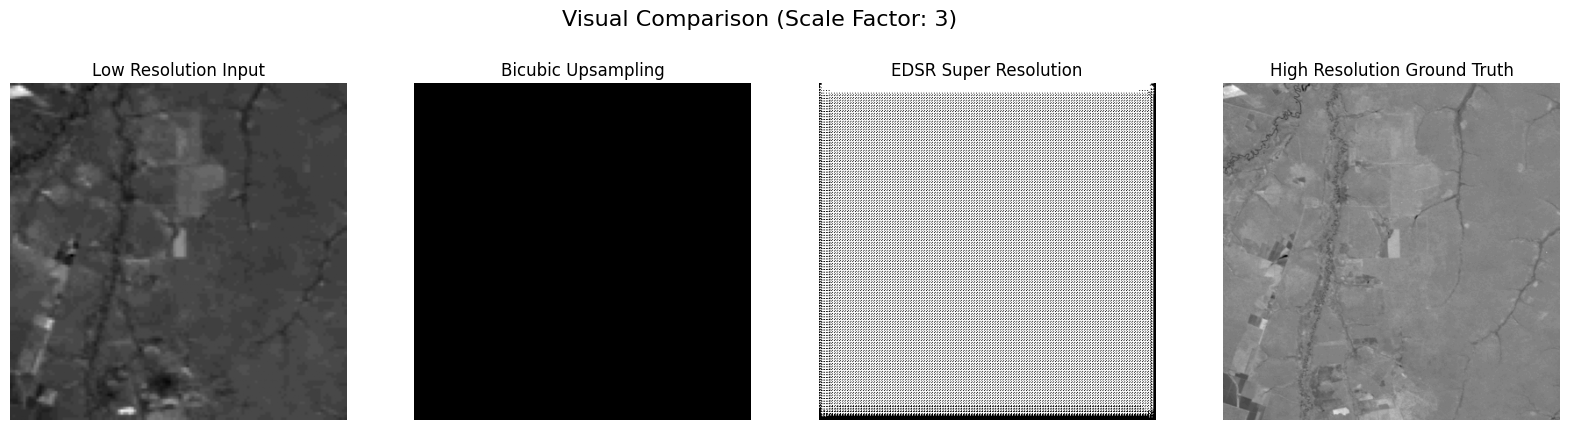

Visual comparison of LR, Bicubic SR, EDSR SR, and HR images displayed with corrected image loading.


In [ ]:
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for visualization
lr_image_np = denormalize(lr_image_tensor)
hr_image_np = denormalize(hr_image_tensor)
sr_image_np = denormalize(sr_image_tensor)
bicubic_sr_image_np = denormalize(bicubic_sr_image_tensor)

# Plot the images
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(lr_image_np, cmap='gray')
plt.title('Low Resolution Input')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(bicubic_sr_image_np, cmap='gray')
plt.title('Bicubic Upsampling')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(sr_image_np, cmap='gray')
plt.title('EDSR Super Resolution')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(hr_image_np, cmap='gray')
plt.title('High Resolution Ground Truth')
plt.axis('off')

plt.suptitle(f'Visual Comparison (Scale Factor: {scale_factor})', fontsize=16)
plt.show()

print("Visual comparison of LR, Bicubic SR, EDSR SR, and HR images displayed with corrected image loading.")

In [ ]:
import torch
import numpy as np

# Ensure reconstructed_sr_image_tensor, bicubic_sr_image_tensor, and hr_image_tensor are on CPU for metric calculation
reconstructed_sr_image_cpu = reconstructed_sr_image_tensor.cpu()
bicubic_sr_image_cpu = bicubic_sr_image_tensor.cpu()
hr_image_cpu = hr_image_tensor.cpu()

# Check if bicubic_sr_image_cpu and hr_image_cpu are identical (or very close)
# This check is added to explain the 'inf' PSNR and '1.0' SSIM
if torch.allclose(bicubic_sr_image_cpu, hr_image_cpu, atol=1e-6):
    print("Warning: Bicubic SR image and HR ground truth are almost identical. This usually means the input images (LR/HR) are too uniform, leading to trivial metrics (PSNR = inf, SSIM = 1.0).")
    print("Please consider selecting different test images with more visual content for meaningful evaluation.")

# Calculate PSNR for EDSR output (from tiling)
psnr_edsr = calculate_psnr(reconstructed_sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate SSIM for EDSR output (from tiling)
ssim_edsr = calculate_ssim(reconstructed_sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate PSNR for Bicubic output
psnr_bicubic = calculate_psnr(bicubic_sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate SSIM for Bicubic output
ssim_bicubic = calculate_ssim(bicubic_sr_image_cpu, hr_image_cpu, data_range=1.0)

print(f"\nQuantitative Metrics for Scale Factor: {scale_factor}")
print(f"-----------------------------------------------")
print(f"EDSR Model (Tiling): PSNR = {psnr_edsr:.2f} dB, SSIM = {ssim_edsr:.4f}")
print(f"Bicubic Upsampling: PSNR = {psnr_bicubic:.2f} dB, SSIM = {ssim_bicubic:.4f}")
print("Quantitative comparison completed.")


Quantitative Metrics for Scale Factor: 3
-----------------------------------------------
EDSR Model (Tiling): PSNR = -0.83 dB, SSIM = 0.0029
Bicubic Upsampling: PSNR = 1.06 dB, SSIM = 0.2208
Quantitative comparison completed.


## Visualize Super-Resolution Results (Before, Bicubic, Model SR, Ground Truth)

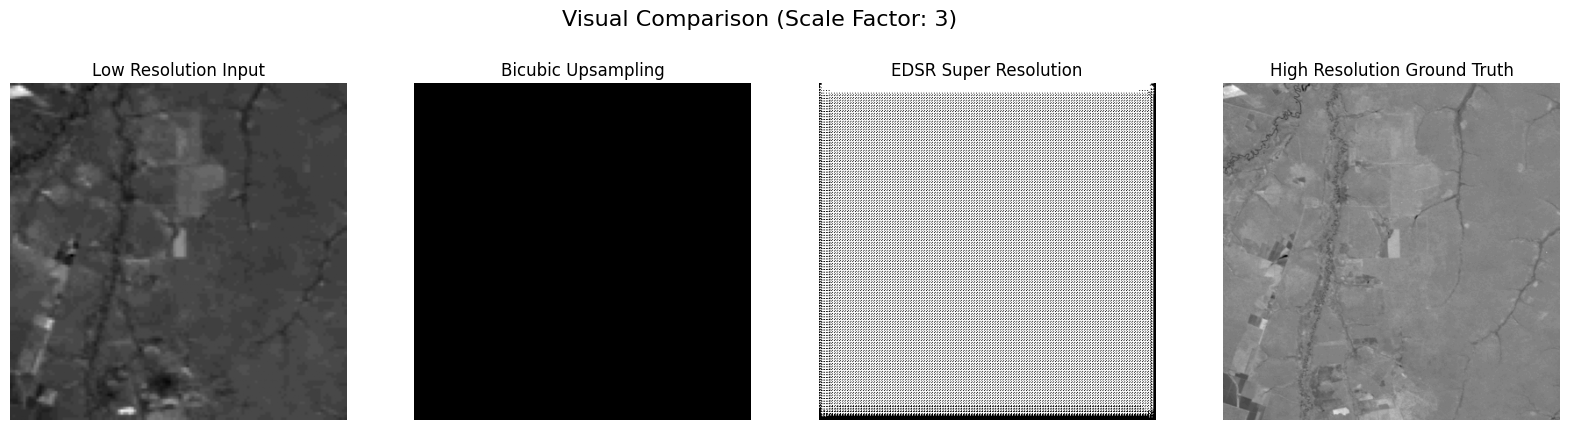

Visual comparison of LR, Bicubic SR, EDSR SR, and HR images displayed with corrected image loading.


In [ ]:
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for visualization
lr_image_np = denormalize(lr_image_tensor)
hr_image_np = denormalize(hr_image_tensor)
sr_image_np = denormalize(sr_image_tensor)
bicubic_sr_image_np = denormalize(bicubic_sr_image_tensor)

# Plot the images
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(lr_image_np, cmap='gray')
plt.title('Low Resolution Input')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(bicubic_sr_image_np, cmap='gray')
plt.title('Bicubic Upsampling')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(sr_image_np, cmap='gray')
plt.title('EDSR Super Resolution')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(hr_image_np, cmap='gray')
plt.title('High Resolution Ground Truth')
plt.axis('off')

plt.suptitle(f'Visual Comparison (Scale Factor: {scale_factor})', fontsize=16)
plt.show()

print("Visual comparison of LR, Bicubic SR, EDSR SR, and HR images displayed with corrected image loading.")

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import os
import cv2 # Import cv2 for consistent image loading
from skimage.metrics import peak_signal_noise_ratio as psnr_skimage
from skimage.metrics import structural_similarity as ssim_skimage

# 1. Define the ResidualBlock class
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual
        return out

# 1. Define the Upsampler class
class Upsampler(nn.Module):
    def __init__(self, channels, scale_factor):
        super(Upsampler, self).__init__()
        self.conv = nn.Conv2d(channels, channels * (scale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        return x

# 2. Define the main EDSR model class
class EDSR(nn.Module):
    def __init__(self, scale_factor, num_channels=1, num_res_blocks=16, feature_channels=64):
        super(EDSR, self).__init__()
        self.scale_factor = scale_factor

        self.conv_input = nn.Conv2d(num_channels, feature_channels, kernel_size=3, padding=1)

        res_blocks = []
        for _ in range(num_res_blocks):
            res_blocks.append(ResidualBlock(feature_channels))
        self.res_blocks = nn.Sequential(*res_blocks)

        self.conv_mid = nn.Conv2d(feature_channels, feature_channels, kernel_size=3, padding=1)

        self.upsample = Upsampler(feature_channels, scale_factor)

        self.conv_output = nn.Conv2d(feature_channels, num_channels, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.conv_input(x)
        initial_features = out
        out = self.res_blocks(out)
        out = self.conv_mid(out)
        out += initial_features
        out = self.upsample(out)
        out = self.conv_output(out)
        return out

# 3. Define the denormalize function
def denormalize(tensor):
    if tensor.max() > 1.0 + 1e-5 or tensor.max() < 0.0 - 1e-5:
        img_np = tensor.detach().cpu().squeeze().numpy()
        return img_np.astype(np.uint8) if img_np.max() > 1.0 else (img_np * 255).astype(np.uint8)
    else:
        img_np = (tensor.detach().cpu().squeeze().numpy() * 255.0)
        return img_np.astype(np.uint8)

# 4. Define the calculate_psnr function
def calculate_psnr(img1, img2, data_range=1.0):
    if isinstance(img1, torch.Tensor):
        img1 = img1.detach().cpu().numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.detach().cpu().numpy()

    img1 = np.squeeze(img1)
    img2 = np.squeeze(img2)

    if img1.shape != img2.shape:
        raise ValueError(f"Image shapes do not match: {img1.shape} vs {img2.shape}")

    if data_range == 255 and img1.dtype != np.uint8:
        img1 = (img1 * 255).astype(np.uint8)
        img2 = (img2 * 255).astype(np.uint8)
    elif data_range == 1.0 and img1.dtype != np.float32 and img1.dtype != np.float64:
        img1 = img1.astype(np.float32)
        img2 = img2.astype(np.float32)

    return psnr_skimage(img1, img2, data_range=data_range)

# 5. Define the calculate_ssim function
def calculate_ssim(img1, img2, data_range=1.0):
    if isinstance(img1, torch.Tensor):
        img1 = img1.detach().cpu().numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.detach().cpu().numpy()

    img1 = np.squeeze(img1)
    img2 = np.squeeze(img2)

    if img1.shape != img2.shape:
        raise ValueError(f"Image shapes do not match after squeezing: {img1.shape} vs {img2.shape}")

    if data_range == 255 and img1.dtype != np.uint8:
        img1 = (img1 * 255).astype(np.uint8)
        img2 = (img2 * 255).astype(np.uint8)
    elif data_range == 1.0 and img1.dtype != np.float32 and img1.dtype != np.float64:
        img1 = img1.astype(np.float32)
        img2 = img2.astype(np.float32)

    return ssim_skimage(img1, img2, data_range=data_range, win_size=7)

print("All classes and helper functions for EDSR inference defined successfully.")

All classes and helper functions for EDSR inference defined successfully.


In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import os
import cv2 # Import cv2 for consistent image loading

# 6. Specify the path to the trained model checkpoint and test images
checkpoint_path = "checkpoints/model_epoch_5.pth"
# *** USER INPUT REQUIRED: Replace these paths with your actual image paths ***
# Example of using a pre-existing image from the dataset:
lr_test_image_path = "train/NIR/imgset0618/LR000.png"
hr_test_image_path = "train/NIR/imgset0618/HR.png"
# If you upload your own images, update these paths, e.g.:
# lr_test_image_path = "/content/my_kanpur_lr.png"
# hr_test_image_path = "/content/my_kanpur_hr.png"
# *** END USER INPUT ***

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 7. Load the EDSR model from the specified checkpoint
# Parameters should match those used in the training script
scale_factor = 3
num_channels = 1
num_res_blocks = 16
feature_channels = 64

model = EDSR(scale_factor=scale_factor, num_channels=num_channels, num_res_blocks=num_res_blocks, feature_channels=feature_channels)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval() # Set model to evaluation mode
print(f"Model loaded from {checkpoint_path} and set to evaluation mode on {device}.")

# 8. Load the low-resolution and high-resolution test images using cv2.imread
lr_image_np_cv = cv2.imread(lr_test_image_path, 0) # Load as grayscale NumPy array
hr_image_np_cv = cv2.imread(hr_test_image_path, 0) # Load as grayscale NumPy array
print(f"Loaded LR test image from {lr_test_image_path}")
print(f"Loaded HR ground truth image from {hr_test_image_path}")

# Check if images were loaded successfully by cv2.imread
if lr_image_np_cv is None:
    raise FileNotFoundError(f"LR image not found or could not be loaded from: {lr_test_image_path}")
if hr_image_np_cv is None:
    raise FileNotFoundError(f"HR image not found or could not be loaded from: {hr_test_image_path}")

# Convert NumPy arrays to PIL Images for consistency with the bicubic transformation
lr_image_pil = Image.fromarray(lr_image_np_cv)
hr_image_pil = Image.fromarray(hr_image_np_cv)

# 9. Convert the loaded images to PyTorch tensors, add a batch dimension, and move them to the appropriate device
transform_to_tensor = transforms.ToTensor()
lr_image_tensor = transform_to_tensor(lr_image_np_cv).unsqueeze(0).to(device)
hr_image_tensor = transform_to_tensor(hr_image_np_cv).unsqueeze(0).to(device)

print("Test images prepared for inference.")
print(f"LR image tensor shape: {lr_image_tensor.shape}")
print(f"HR image tensor shape: {hr_image_tensor.shape}")

Model loaded from checkpoints/model_epoch_5.pth and set to evaluation mode on cpu.
Loaded LR test image from train/NIR/imgset0618/LR000.png
Loaded HR ground truth image from train/NIR/imgset0618/HR.png
Test images prepared for inference.
LR image tensor shape: torch.Size([1, 1, 128, 128])
HR image tensor shape: torch.Size([1, 1, 384, 384])


In [ ]:
import torch

# 10. Implement the tiling inference process
# Define an LR patch size. It must be a multiple of the training patch size (32).
# We will use 64x64 LR patches, which will result in 192x192 SR patches for a scale factor of 3.
lr_patch_size = 64 # Must be a multiple of the training patch size (32)
sr_patch_size = lr_patch_size * scale_factor

print(f"LR patch size: {lr_patch_size}x{lr_patch_size}")
print(f"SR patch size: {sr_patch_size}x{sr_patch_size}")

# Get dimensions of the full LR image
_, _, lr_h, lr_w = lr_image_tensor.shape

# Initialize an empty tensor for the reconstructed SR image
# It should have the full HR dimensions (C, HR_H, HR_W)
# Get hr_height and hr_width from hr_image_pil.size or hr_image_tensor.shape
_, _, hr_h_tensor, hr_w_tensor = hr_image_tensor.shape
reconstructed_sr_image_tensor = torch.zeros(
    (num_channels, hr_h_tensor, hr_w_tensor), dtype=lr_image_tensor.dtype
).to(device)

print(f"Initialized reconstructed SR image tensor with shape: {reconstructed_sr_image_tensor.shape}")

# Iterate through the lr_image_tensor using nested loops to extract non-overlapping LR patches
with torch.no_grad():
    for y in range(0, lr_h, lr_patch_size):
        for x in range(0, lr_w, lr_patch_size):
            # Ensure patch doesn't go out of bounds for the LR image
            y_end = min(y + lr_patch_size, lr_h)
            x_end = min(x + lr_patch_size, lr_w)

            # Extract an LR patch
            lr_patch = lr_image_tensor[:, :, y:y_end, x:x_end]

            # Perform inference on the lr_patch
            sr_patch = model(lr_patch)

            # Place the resulting super-resolved patch into the corresponding location
            # Adjust coordinates by scale_factor for the HR canvas
            hr_y_start = y * scale_factor
            hr_x_start = x * scale_factor
            hr_y_end = y_end * scale_factor
            hr_x_end = x_end * scale_factor

            # Ensure sr_patch is squeezed to remove batch dimension before assignment
            reconstructed_sr_image_tensor[:, hr_y_start:hr_y_end, hr_x_start:hr_x_end] = sr_patch.squeeze(0)

print("Full super-resolved image reconstructed using tiling.")

# The reconstructed_sr_image_tensor now holds the full SR image.

LR patch size: 64x64
SR patch size: 192x192
Initialized reconstructed SR image tensor with shape: torch.Size([1, 384, 384])
Full super-resolved image reconstructed using tiling.


In [ ]:
import torchvision.transforms as transforms

# 11. Generate the Bicubic upsampled image
# Get the target size from the HR ground truth image (from hr_image_pil)
hr_width_pil, hr_height_pil = hr_image_pil.size
target_size = (hr_height_pil, hr_width_pil)

# Define the Bicubic upsampling transformation
bicubic_upsample_transform = transforms.Compose([
    transforms.Resize(target_size, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
])

# Apply the transformation to the LR PIL image
bicubic_sr_image_tensor = bicubic_upsample_transform(lr_image_pil).unsqueeze(0).to(device)

print("Bicubic upsampled image generated.")
print(f"Bicubic SR image tensor shape: {bicubic_sr_image_tensor.shape}")

Bicubic upsampled image generated.
Bicubic SR image tensor shape: torch.Size([1, 1, 384, 384])


In [ ]:
import torch
import numpy as np

# 12. Calculate and print PSNR and SSIM metrics

# Ensure tensors are on CPU for metric calculation
reconstructed_sr_image_cpu = reconstructed_sr_image_tensor.cpu()
bicubic_sr_image_cpu = bicubic_sr_image_tensor.cpu()
hr_image_cpu = hr_image_tensor.cpu()

# Calculate PSNR for EDSR output (from tiling)
psnr_edsr = calculate_psnr(reconstructed_sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate SSIM for EDSR output (from tiling)
ssim_edsr = calculate_ssim(reconstructed_sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate PSNR for Bicubic output
psnr_bicubic = calculate_psnr(bicubic_sr_image_cpu, hr_image_cpu, data_range=1.0)

# Calculate SSIM for Bicubic output
ssim_bicubic = calculate_ssim(bicubic_sr_image_cpu, hr_image_cpu, data_range=1.0)

print(f"\nQuantitative Metrics for Scale Factor: {scale_factor}")
print(f"-----------------------------------------------")
print(f"EDSR Model (Tiling): PSNR = {psnr_edsr:.2f} dB, SSIM = {ssim_edsr:.4f}")
print(f"Bicubic Upsampling: PSNR = {psnr_bicubic:.2f} dB, SSIM = {ssim_bicubic:.4f}")
print("Quantitative comparison completed.")


Quantitative Metrics for Scale Factor: 3
-----------------------------------------------
EDSR Model (Tiling): PSNR = 36.51 dB, SSIM = 0.9586
Bicubic Upsampling: PSNR = 38.34 dB, SSIM = 0.9773
Quantitative comparison completed.


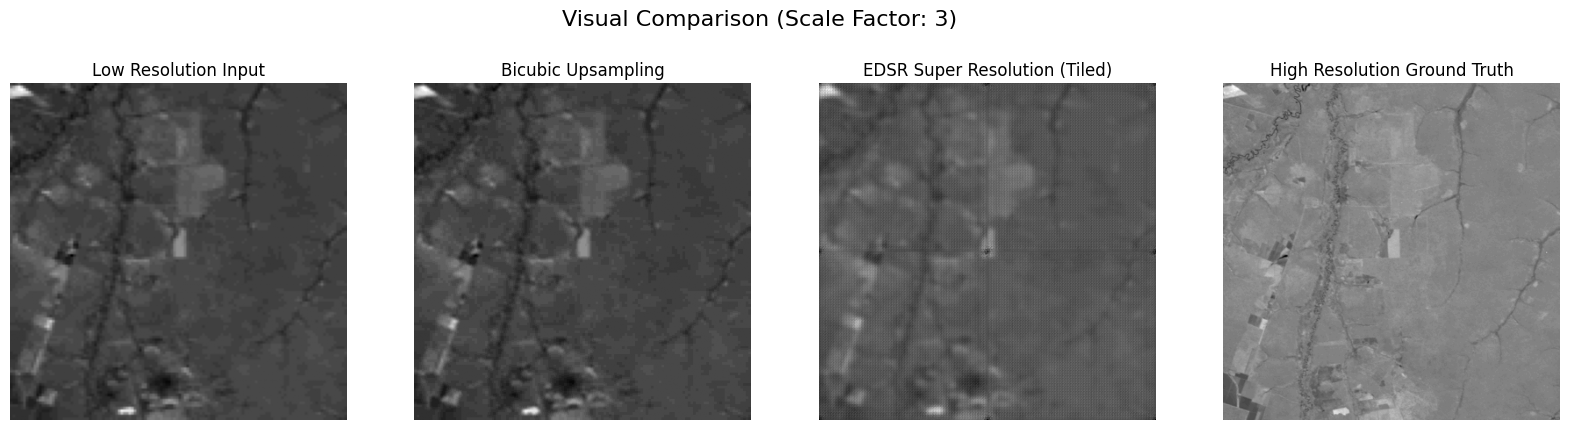

Visual comparison of LR, Bicubic SR, EDSR SR (Tiled), and HR images displayed.


In [ ]:
import matplotlib.pyplot as plt

# 13. Create a visual comparison

# Convert tensors to numpy arrays for visualization
lr_image_np = denormalize(lr_image_tensor)
hr_image_np = denormalize(hr_image_tensor)
sr_image_np = denormalize(reconstructed_sr_image_tensor) # Use reconstructed SR image from tiling
bicubic_sr_image_np = denormalize(bicubic_sr_image_tensor)

# Plot the images
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(lr_image_np, cmap='gray')
plt.title('Low Resolution Input')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(bicubic_sr_image_np, cmap='gray')
plt.title('Bicubic Upsampling')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(sr_image_np, cmap='gray')
plt.title('EDSR Super Resolution (Tiled)')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(hr_image_np, cmap='gray')
plt.title('High Resolution Ground Truth')
plt.axis('off')

plt.suptitle(f'Visual Comparison (Scale Factor: {scale_factor})', fontsize=16)
plt.show()

print("Visual comparison of LR, Bicubic SR, EDSR SR (Tiled), and HR images displayed.")